In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import json
import pandas as pd

In [2]:
def get_y_val(x, xs, ys):
    for i in range(xs.shape[0]):
        if xs[i] > x:
            # This is upper bound, previous is lower bound
            if i == 0:
                end, start = xs[i], 0
                l = (x-start)/(end-start)
                return ys[i]#(l)*ys[i]
            end, start = xs[i], xs[i-1]
            l = (x-start)/(end-start)
            return (l)*ys[i] + (1-l)*ys[i-1]
    return ys[len(ys)-1]

def get_average_plot(data):
    end_time = 0
    for es in data["epochs"]:
        end_time = max(end_time, np.max(es))
    xs = np.array(range(0, int(end_time)))
    yss = np.array([[get_y_val(x, data["epochs"][di], data["accuracies"][di]) for x in xs] for di in range(len(data["epochs"]))])
    ys_avg = np.median(yss, axis=0)#np.mean(yss, axis=0)
    ys_q75, ys_q25 = np.percentile(yss, [75 ,25], axis=0)
    #ys_std = np.std(yss, axis=0)
    return xs, ys_avg, ys_q75, ys_q25

def average_plot(data, color=(0.02745098, 0.50588235, 0.87058824), plot_std=True, label=None, dashed=False):
    xs, ys_avg, ys_q75, ys_q25 = get_average_plot(data)
    if plot_std:
        plt.fill_between(xs, ys_q25, ys_q75, color=(color[0], color[1], color[2], 0.25))
    if dashed:
        plt.plot(xs, ys_avg, "--", color=color, label=label)
    else:
        plt.plot(xs, ys_avg, color=color, label=label)
        

In [3]:
def setup_accuracy_graph(title, zoom=None, legend=True):
    plt.xticks([x for x in range(0, 21, 1)])
    if zoom is not None:
        plt.ylim(zoom[0], zoom[1])
        #plt.yticks([x for x in range(zoom[0], zoom[1]+1, 1)])
        plt.yticks([x for x in range(0, 110, 5) if (x <= zoom[1]+1 and x >= zoom[0])])
    else:
        plt.ylim(0, 100)
        #plt.yticks([x for x in range(0, 110, 10)])
        plt.yticks([x for x in range(0, 110, 5)])
    plt.xlim(0, 20)
    plt.xlabel("Training Step")
    plt.ylabel("Median Accuracy (%)")
    plt.grid()
    if legend:
        plt.legend()
    #plt.title(title)
    print(r"\center{\textbf{"+title+r"}} \\")

In [4]:
def colors(a, b, n):
    def lerp(a,b,x):
        return (1-x)*a + x*b
    x = 1/(n-1)
    cols = []
    for ni in range(n):
        xi = ni*x
        cols.append((lerp(a[0], b[0], xi), lerp(a[1], b[1], xi), lerp(a[2], b[2], xi)))
    return cols

In [5]:
def read_database(path="./data"):
    db = []
    for filename in listdir(path):
        with open(path+"/"+filename, "r") as f:
            js = json.loads(f.read())
            exmajor, exminor = int(filename.split(".")[0][len("test"):]), int(filename.split(".")[1])
            js["exmajor"], js["exminor"] = exmajor, exminor
            db.append(js)
    return db

def find_data(db, condition=lambda x: True):
    epochs = []
    data = []
    msds = []
    for d in db:
        if condition(d):
            epochs.extend([np.array(x) for x in d['epochs']])
            data.extend([np.array(x) for x in d['accuracies']])
            msds.extend([np.array(x) for x in d['msds']])
    if len(data) == 0:
        print("Cant find data")
    return {"epochs":np.array(epochs), "accuracies":np.array(data), "msds":np.array(msds)}

In [6]:
db = read_database()

In [7]:
cols = [(0, 63/255, 92/255), (188/255, 80/255, 144/255), (255/255, 166/255, 0)]#colors((0,1,0), (1,0,0),3)

In [8]:
save_path = "../../conference/plots"

\center{\textbf{Accuracy by Training Step for 1000 Samples for Different Densities}} \\


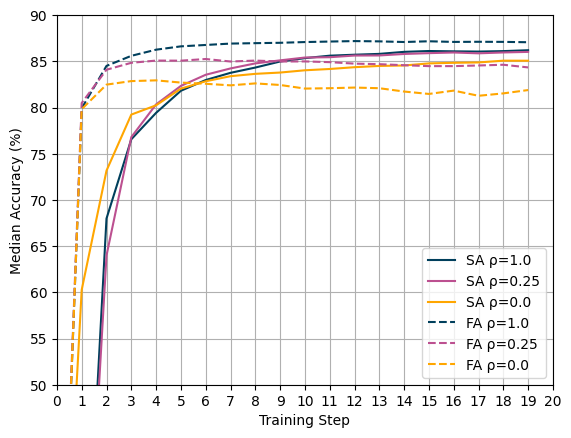

\center{\textbf{Accuracy by Training Step for 100 Samples for Different Densities}} \\


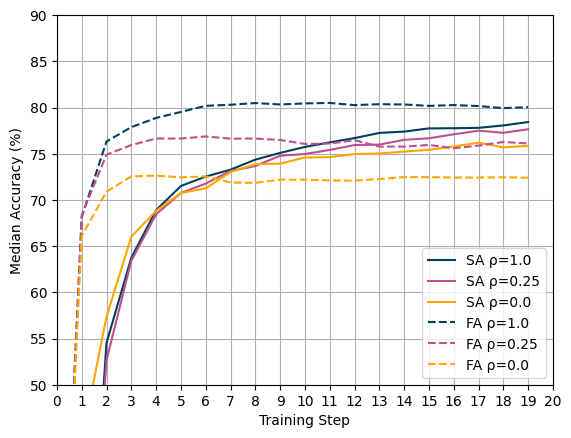

\center{\textbf{Accuracy by Training Step for 25 Samples for Different Densities}} \\


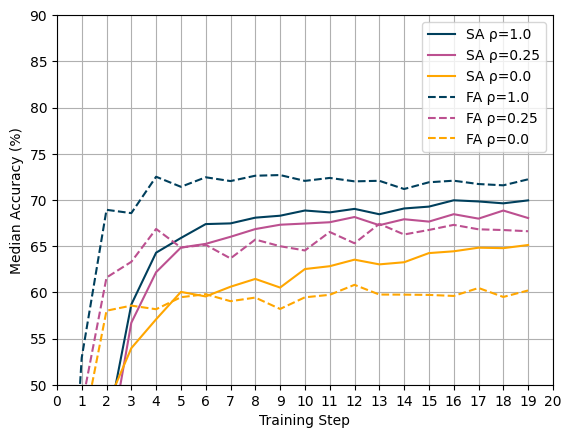

In [9]:
# sparsely connected nodes
zoom = (50,90)
for (numsamples,add) in [(1000,0), (100,1), (25,2)]:
    for x in [(3, 1.0, cols[0], 8),(12, 0.25, cols[1], 3),(15, 0.0, cols[2], 1)]:
        average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == x[0]+add), label="SA ρ=%s"%(x[1]), color=x[2], plot_std=False)
    for x in [(36, 1.0, cols[0], 8),(45, 0.25, cols[1], 3),(48, 0.0, cols[2], 1)]:
        average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == x[0]+add), label="FA ρ=%s"%(x[1]), color=x[2], plot_std=False, dashed=True)
    setup_accuracy_graph("Accuracy by Training Step for %s Samples for Different Densities"%numsamples, zoom=zoom)
    fig = plt.gcf()
    fig.savefig(save_path+"/conf_sparse_ns%s.png"%numsamples, bbox_inches='tight')
    plt.show()

\center{\textbf{Accuracy by Training Step for 1000 Samples for Different Densities with 3 Classes}} \\


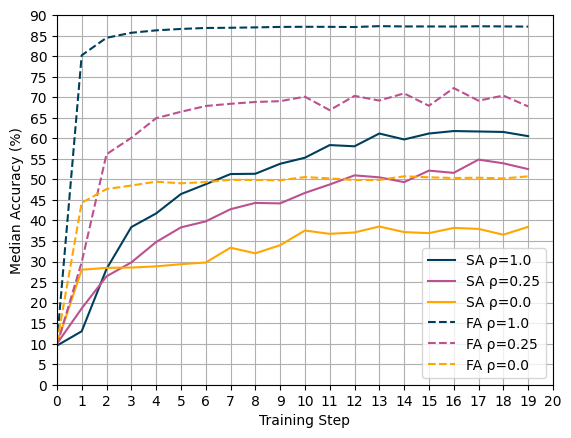

\center{\textbf{Accuracy by Training Step for 100 Samples for Different Densities with 3 Classes}} \\


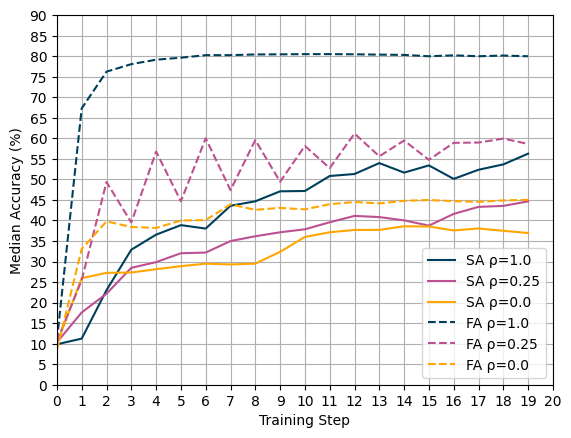

\center{\textbf{Accuracy by Training Step for 25 Samples for Different Densities with 3 Classes}} \\


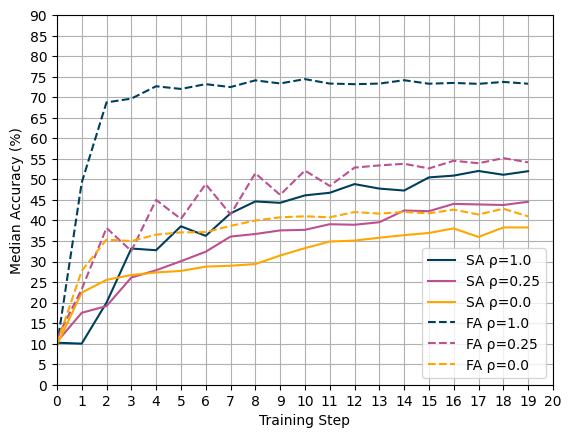

In [10]:
# sparsely connected nodes with class restrictions
zoom = (0,90)
for (numsamples,add) in [(1000,0), (100,1), (25,2)]:
    for x in [(21, 1.0, cols[0], 8),(30, 0.25, cols[1], 3),(33, 0.0, cols[2], 1)]:
        average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == x[0]+add), label="SA ρ=%s"%(x[1]), color=x[2], plot_std=False)
    for x in [(51, 1.0, cols[0], 8),(54, 0.25, cols[1], 3),(57, 0.0, cols[2], 1)]:
        average_plot(find_data(db, condition=lambda ex: ex["exmajor"] == x[0]+add), label="FA ρ=%s"%(x[1]), color=x[2], plot_std=False, dashed=True)
    setup_accuracy_graph("Accuracy by Training Step for %s Samples for Different Densities with 3 Classes"%numsamples, zoom=zoom)
    fig = plt.gcf()
    fig.savefig(save_path+"/conf_sparse_ns%s_cl3.png"%numsamples, bbox_inches='tight')
    plt.show()